### Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
print(device)

cpu


### Data Loading & Cleaning

In [3]:
# Load dataset
data_path = 'spain_energy_meteo_data.csv'
df = pd.read_csv(data_path, parse_dates=['Date'], index_col='Date')

# Use all features for input
all_features = df.columns.tolist()

# Handle missing values
data = df.fillna(method='ffill')

C:\Users\Student11\AppData\Local\Temp\ipykernel_22816\1784617096.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df.fillna(method='ffill')


In [4]:
display(data)

,Electricity Demand,Hydropower reservoir,Hydropower run-of-river,Solar PV Power,Wind Power Onshore,Global Horizontal Irradiance,Mean Sea Level Pressure,Air Temperature,Total Precipitation,Wind Speed_x,Wind Speed_y
Date,,,,,,,,,,,
1980-01-01,555442.4,75105.17,27625.16,7414.011781,241681.204853,63.712332,101892.963958,282.782622,0.001628,3.967427,6.825222
1980-01-02,668316.5,74774.20,27676.85,9667.063190,141812.976918,76.356610,102279.375083,280.568923,0.000416,3.075484,5.265852
1980-01-03,692024.2,74066.41,28220.82,14965.925374,28256.394755,103.318422,102547.714417,277.943976,0.000005,1.731207,2.884409
1980-01-04,693162.4,74689.07,28344.47,14105.305812,36945.997648,99.630959,102265.270542,278.233487,0.000728,1.816051,3.011657
1980-01-05,624292.7,74882.60,28480.01,11298.820055,72234.129754,84.680324,102225.539208,278.408883,0.000794,2.186170,3.756692
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,700110.3,66117.47,30107.25,15865.123549,95783.220015,143.957778,102796.901583,282.747021,0.001501,2.496270,4.200499
2025-02-25,725569.3,66875.40,30080.05,11142.786919,138396.892727,110.305063,102545.382667,282.309362,0.001773,3.193231,5.403183
2025-02-26,724012.9,64955.26,29987.86,21820.251802,42084.705472,187.718245,102601.983000,280.700744,0.000090,2.010059,3.276983


In [5]:
data_y_energy = data[['Electricity Demand', 'Hydropower reservoir', 'Hydropower run-of-river', 'Solar PV Power', 'Wind Power Onshore']]

targets_energy = data_y_energy.columns.tolist()

print(targets_energy)
display(data_y_energy)

['Electricity Demand', 'Hydropower reservoir', 'Hydropower run-of-river', 'Solar PV Power', 'Wind Power Onshore']


,Electricity Demand,Hydropower reservoir,Hydropower run-of-river,Solar PV Power,Wind Power Onshore
Date,,,,,
1980-01-01,555442.4,75105.17,27625.16,7414.011781,241681.204853
1980-01-02,668316.5,74774.20,27676.85,9667.063190,141812.976918
1980-01-03,692024.2,74066.41,28220.82,14965.925374,28256.394755
1980-01-04,693162.4,74689.07,28344.47,14105.305812,36945.997648
1980-01-05,624292.7,74882.60,28480.01,11298.820055,72234.129754
...,...,...,...,...,...
2025-02-24,700110.3,66117.47,30107.25,15865.123549,95783.220015
2025-02-25,725569.3,66875.40,30080.05,11142.786919,138396.892727
2025-02-26,724012.9,64955.26,29987.86,21820.251802,42084.705472


In [6]:
data_y_meteo = data[['Global Horizontal Irradiance', 'Mean Sea Level Pressure', 'Air Temperature', 'Total Precipitation', 'Wind Speed_x', 'Wind Speed_y']]

targets_meteo = data_y_meteo.columns.tolist()

print(targets_meteo)
display(data_y_meteo)

['Global Horizontal Irradiance', 'Mean Sea Level Pressure', 'Air Temperature', 'Total Precipitation', 'Wind Speed_x', 'Wind Speed_y']


,Global Horizontal Irradiance,Mean Sea Level Pressure,Air Temperature,Total Precipitation,Wind Speed_x,Wind Speed_y
Date,,,,,,
1980-01-01,63.712332,101892.963958,282.782622,0.001628,3.967427,6.825222
1980-01-02,76.356610,102279.375083,280.568923,0.000416,3.075484,5.265852
1980-01-03,103.318422,102547.714417,277.943976,0.000005,1.731207,2.884409
1980-01-04,99.630959,102265.270542,278.233487,0.000728,1.816051,3.011657
1980-01-05,84.680324,102225.539208,278.408883,0.000794,2.186170,3.756692
...,...,...,...,...,...,...
2025-02-24,143.957778,102796.901583,282.747021,0.001501,2.496270,4.200499
2025-02-25,110.305063,102545.382667,282.309362,0.001773,3.193231,5.403183
2025-02-26,187.718245,102601.983000,280.700744,0.000090,2.010059,3.276983


### Data Normalization

In [7]:
# Normalize data
# scalerX = MinMaxScaler()
scalerX = StandardScaler()
# scalerX = RobustScaler()
dataX_scaled = scalerX.fit_transform(data)

# scalerY = MinMaxScaler()
scalerY_energy = StandardScaler()
# scalerY = RobustScaler()
data_y_energy_scaled = scalerY_energy.fit_transform(data_y_energy)

scalerYmeteo = StandardScaler()
# scalerYmeteo = MinMaxScaler()
# scalerYmeteo = RobustScaler()
data_y_meteo_scaled = scalerYmeteo.fit_transform(data_y_meteo)

In [8]:
print(dataX_scaled.shape, data_y_energy_scaled.shape, data_y_meteo_scaled.shape)

(16496, 11) (16496, 5) (16496, 6)


### Sequence Generation for LSTM

In [9]:
def create_sequences(dataX, data_y, seq_length, prediction_horizon):
    X, y = [], []
    for i in range(len(data) - seq_length - prediction_horizon + 1):
        X.append(dataX[i:i+seq_length])
        y.append(data_y[i+seq_length+prediction_horizon-1])
    return np.array(X), np.array(y)

seq_length = 30*10  # Use past 30 days to predict
prediction_horizon = 30  # Predict 30 days ahead

X, y1 = create_sequences(dataX_scaled, data_y_energy_scaled, seq_length, prediction_horizon)
X, y2 = create_sequences(dataX_scaled, data_y_meteo_scaled, seq_length, prediction_horizon)

In [10]:
print(X.shape, y1.shape) # (samples, sequence length, features), (samples, features)
print(X.shape, y2.shape) # (samples, sequence length, features), (samples, features)

(16167, 300, 11) (16167, 5)
(16167, 300, 11) (16167, 6)


### GRU Model Definition

In [11]:
class GRUModelEnergy(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(GRUModelEnergy, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Initialize GRU weights
        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        # Initialize FC weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
    
    def forward(self, x, h0=None):
        # If hidden state is not provided, initialize it as zeros
        if h0 is None:
            h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        
        gru_out, hn = self.gru(x, h0)
        x = self.dropout(gru_out[:, -1, :])
        x = self.fc1(x)  # Use the last output of the GRU
        x = self.relu(x)
        return self.fc2(x), hn

input_size = len(all_features)
hidden_size = 200  # Increased hidden size for better feature learning
num_layers = 4  # Increased number of layers for deeper representation
output_size = len(targets_energy)
dropout = 0.1  # Added dropout for regularization

gru_model_energy = GRUModelEnergy(input_size, hidden_size, num_layers, output_size, dropout).to(device)

print(f"Nb of hyperparamters in {gru_model_energy.__class__.__name__}: {sum(p.numel() for p in gru_model_energy.parameters() if p.requires_grad):,}")

Nb of hyperparamters in GRUModelEnergy: 872,005


In [12]:
class GRUModelMeteo(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(GRUModelMeteo, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        
        # Initialize GRU weights
        for name, param in self.gru.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0)
        
        # Initialize FC weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
    
    def forward(self, x, h0=None):
        # If hidden state is not provided, initialize it as zeros
        if h0 is None:
            h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        
        gru_out, hn = self.gru(x, h0)
        x = self.dropout(gru_out[:, -1, :])
        x = self.fc1(x)  # Use the last output of the GRU
        x = self.relu(x)
        return self.fc2(x), hn

input_size = len(all_features)
hidden_size = 200  # Increased hidden size for better feature learning
num_layers = 4  # Increased number of layers for deeper representation
output_size = len(targets_meteo)
dropout = 0.1  # Added dropout for regularization

gru_model_meteo = GRUModelMeteo(input_size, hidden_size, num_layers, output_size, dropout).to(device)

print(f"Nb of hyperparamters in {gru_model_meteo.__class__.__name__}: {sum(p.numel() for p in gru_model_meteo.parameters() if p.requires_grad):,}")

Nb of hyperparamters in GRUModelMeteo: 872,106


In [13]:
path_model_energy = r'GRUModelEnergy.pth'
gru_model_energy.load_state_dict(torch.load(path_model_energy, map_location=torch.device(device)))

<All keys matched successfully>

In [14]:
path_model_meteo = r'GRUModelMeteo.pth'
gru_model_meteo.load_state_dict(torch.load(path_model_meteo, map_location=torch.device(device)))

<All keys matched successfully>

### Prediction for Next Month

In [15]:
# Take last sequence and predict next month
last_sequence = X[-2]
print(last_sequence.shape)
last_sequence_y_energy = y1[-1]
print(last_sequence_y_energy.shape)
last_sequence_y_meteo = y2[-1]
print(last_sequence_y_meteo.shape)

(300, 11)
(5,)
(6,)


In [16]:
def predict_next_month_uncertinaty(model_energy, model_meteo, last_data, steps=30, nb_iter=100):
    model_energy.train()
    model_meteo.train()

    predictions_energy = []
    predictions_meteo = []

    input = torch.tensor(last_data, dtype=torch.float32).unsqueeze(0)
    print(input.shape)
    print(input.device)

    for _ in range(steps):
        print(f"step : {_} / {steps}")
        with torch.no_grad():
            predict_monte_carlo_energy = []
            predict_monte_carlo_meteo = []
            for _ in range(nb_iter):
                # print(f"iter : {_} / {nb_iter}")
                input = input.to(device)
                
                h0 = None  # Initialize hidden and cell states
                
                # outputs1 : (1, 5)
                outputs1, h0 = model_energy(input, h0)
                
                # outputs2 : (1, 6)
                outputs2, h0 = model_meteo(input, h0)
                
                # Detach hidden and cell states to prevent backpropagation through the entire sequence
                h0 = h0.detach()
                
                predict_monte_carlo_energy.append(outputs1.cpu().numpy())
                predict_monte_carlo_meteo.append(outputs2.cpu().numpy())
            
            predictions_energy.append(predict_monte_carlo_energy)
            predictions_meteo.append(predict_monte_carlo_meteo)
        
        
        # Combine outputs1 and outputs2 to form the 11 features
        combined_outputs = torch.cat((outputs2, outputs1), dim=1)
        # print(combined_outputs.shape) # (1, 11)

        # Add the combined outputs to the input sequence
        # print(input[:, 1:, :].shape) # (1, 299, 11)
        input = torch.cat((input[:, 1:, :], combined_outputs.unsqueeze(0)), dim=1)

    print(f"nb of pedicctions : {len(predictions_energy)}") # 30
    print(f"nb of pedicctions : {len(predictions_meteo)}") 
    # print(f"shape of one prediciton : {predictions_energy[0].shape}") # (1, 5)
    
    return predictions_energy, predictions_meteo

In [17]:
preds_mc_energy, preds_mc_meteo = predict_next_month_uncertinaty(gru_model_energy, gru_model_meteo, last_sequence, steps=prediction_horizon*2, nb_iter=10)

torch.Size([1, 300, 11])
cpu
step : 0 / 60
step : 1 / 60
step : 2 / 60
step : 3 / 60
step : 4 / 60
step : 5 / 60
step : 6 / 60
step : 7 / 60
step : 8 / 60
step : 9 / 60
step : 10 / 60
step : 11 / 60
step : 12 / 60
step : 13 / 60
step : 14 / 60
step : 15 / 60
step : 16 / 60
step : 17 / 60
step : 18 / 60
step : 19 / 60
step : 20 / 60
step : 21 / 60
step : 22 / 60
step : 23 / 60
step : 24 / 60
step : 25 / 60
step : 26 / 60
step : 27 / 60
step : 28 / 60
step : 29 / 60
step : 30 / 60
step : 31 / 60
step : 32 / 60
step : 33 / 60
step : 34 / 60
step : 35 / 60
step : 36 / 60
step : 37 / 60
step : 38 / 60
step : 39 / 60
step : 40 / 60
step : 41 / 60
step : 42 / 60
step : 43 / 60
step : 44 / 60
step : 45 / 60
step : 46 / 60
step : 47 / 60
step : 48 / 60
step : 49 / 60
step : 50 / 60
step : 51 / 60
step : 52 / 60
step : 53 / 60
step : 54 / 60
step : 55 / 60
step : 56 / 60
step : 57 / 60
step : 58 / 60
step : 59 / 60
nb of pedicctions : 60
nb of pedicctions : 60


In [ ]:
# preds_mc_energy = np.squeeze(preds_mc_energy, axis=2)
# print(preds_mc_energy.shape)

# preds_mc_meteo = np.squeeze(preds_mc_meteo, axis=2)
# print(preds_mc_meteo.shape)

(60, 10, 1, 5)
(60, 10, 1, 6)


In [19]:
a = 

SyntaxError: invalid syntax (2792523948.py, line 1)

In [21]:
# Inverse transform the predictions on preds_mc
preds_mc_energy_inv = []
preds_mc_meteo_inv = []
for i in range(preds_mc_energy.shape[1]):
    print(f"preds_mc_energy.shape : {preds_mc_energy[:,i].shape}")
    preds_mc_energy_inv.append(scalerY_energy.inverse_transform(preds_mc_energy[:,i].squeeze(axis=1)))
    preds_mc_meteo_inv.append(scalerYmeteo.inverse_transform(preds_mc_meteo[:,i].squeeze(axis=1)))

preds_mc_energy.shape : (60, 1, 5)
preds_mc_energy.shape : (60, 1, 5)
preds_mc_energy.shape : (60, 1, 5)
preds_mc_energy.shape : (60, 1, 5)
preds_mc_energy.shape : (60, 1, 5)
preds_mc_energy.shape : (60, 1, 5)
preds_mc_energy.shape : (60, 1, 5)
preds_mc_energy.shape : (60, 1, 5)
preds_mc_energy.shape : (60, 1, 5)
preds_mc_energy.shape : (60, 1, 5)


In [22]:
preds_mc_energy_inv = np.array(preds_mc_energy_inv)
preds_mc_energy_inv = np.transpose(preds_mc_energy_inv, (1, 0, 2))
preds_mc_energy_inv = np.expand_dims(preds_mc_energy_inv, axis=2)
print(preds_mc_energy_inv.shape)  # (60, 10, 1, 5)

preds_mc_meteo_inv = np.array(preds_mc_meteo_inv)
preds_mc_meteo_inv = np.transpose(preds_mc_meteo_inv, (1, 0, 2))
preds_mc_meteo_inv = np.expand_dims(preds_mc_meteo_inv, axis=2)
print(preds_mc_meteo_inv.shape)  # (60, 10, 1, 6)

(60, 10, 1, 5)
(60, 10, 1, 6)


In [23]:
df.index[-prediction_horizon]

Timestamp('2025-01-30 00:00:00')

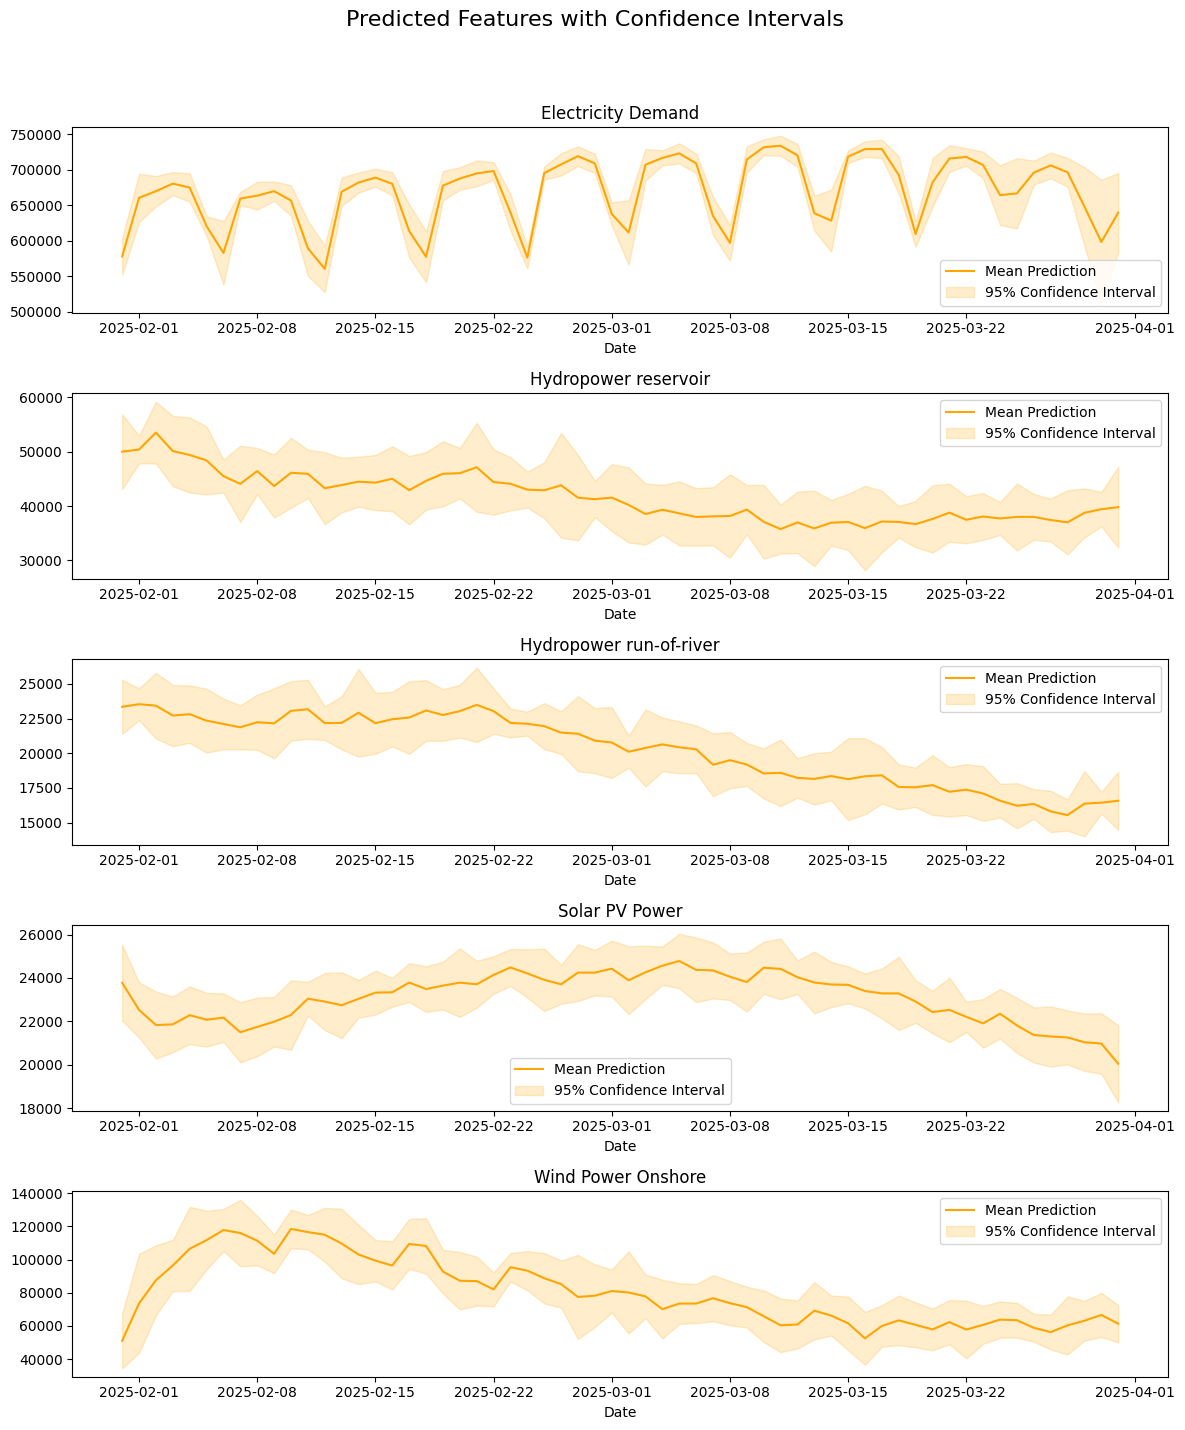

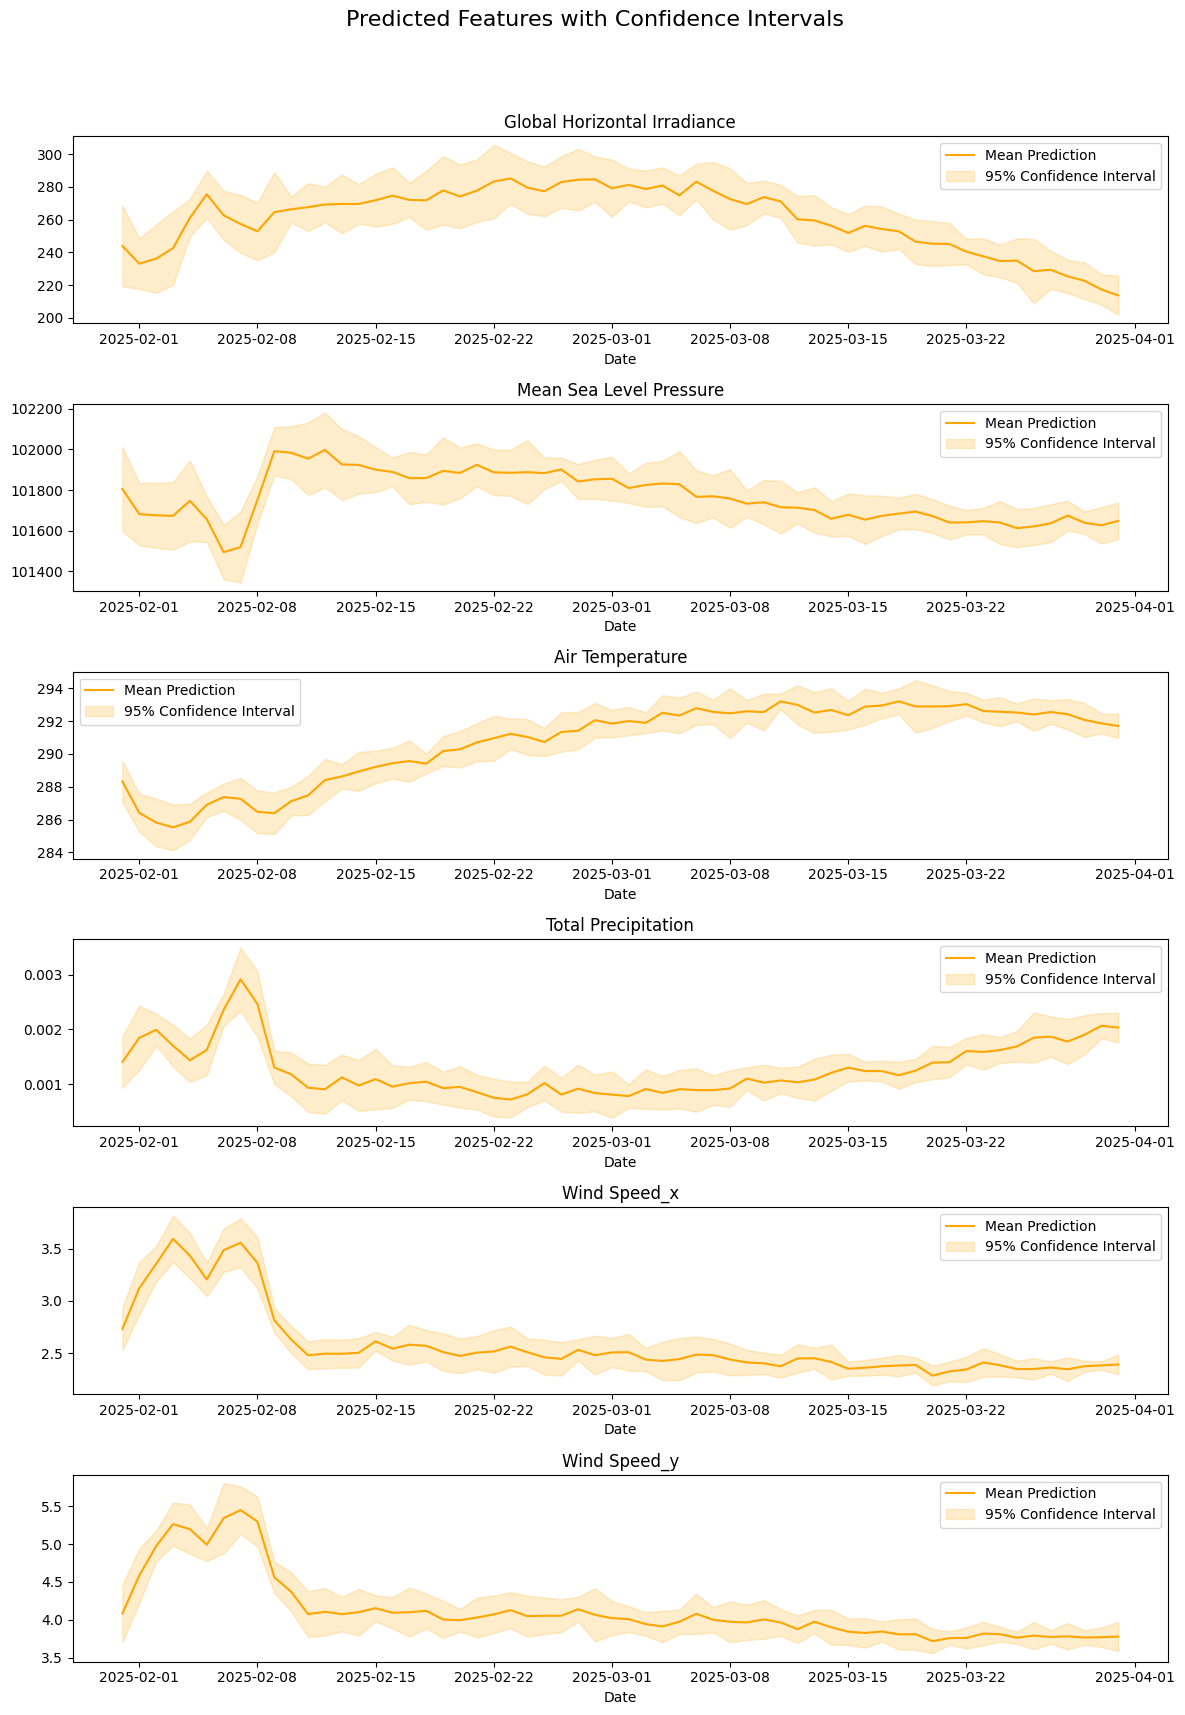

In [25]:
# Generate future dates for the x-axis
future_dates = pd.date_range(start=df.index[-prediction_horizon] + pd.Timedelta(days=1), periods=prediction_horizon*2, freq='D')

def plot_predictions_uncertainty(predictions, targets):
    # Calculate mean, lower bound, and upper bound for the interval of confidence
    mean_pred = predictions.mean(axis=1).squeeze(axis=1)  # Mean across iterations
    std_pred = predictions.std(axis=1).squeeze(axis=1)    # Standard deviation across iterations


    lower_bound = mean_pred - 1.96 * std_pred  # 95% confidence interval lower bound
    upper_bound = mean_pred + 1.96 * std_pred  # 95% confidence interval upper bound
    
    num_features = len(targets)

    # Plot each feature with confidence intervals
    plt.figure(figsize=(12, num_features * 3))
    plt.suptitle("Predicted Features with Confidence Intervals", fontsize=16)

    for i, feature in enumerate(targets):
        plt.subplot(num_features, 1, i + 1)
        plt.plot(future_dates, mean_pred[:, i], label="Mean Prediction", color='orange')
        plt.fill_between(future_dates, lower_bound[:, i], upper_bound[:, i], color='orange', alpha=0.2, label="95% Confidence Interval")
        plt.title(feature)
        plt.xlabel("Date")
        plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
plot_predictions_uncertainty(preds_mc_energy_inv, targets_energy)
plot_predictions_uncertainty(preds_mc_meteo_inv, targets_meteo)

In [26]:
# Extract the actual data for the last sequence of days
actual_data = data_y_energy.iloc[-seq_length:]

# Generate dates for the actual data
actual_dates = actual_data.index

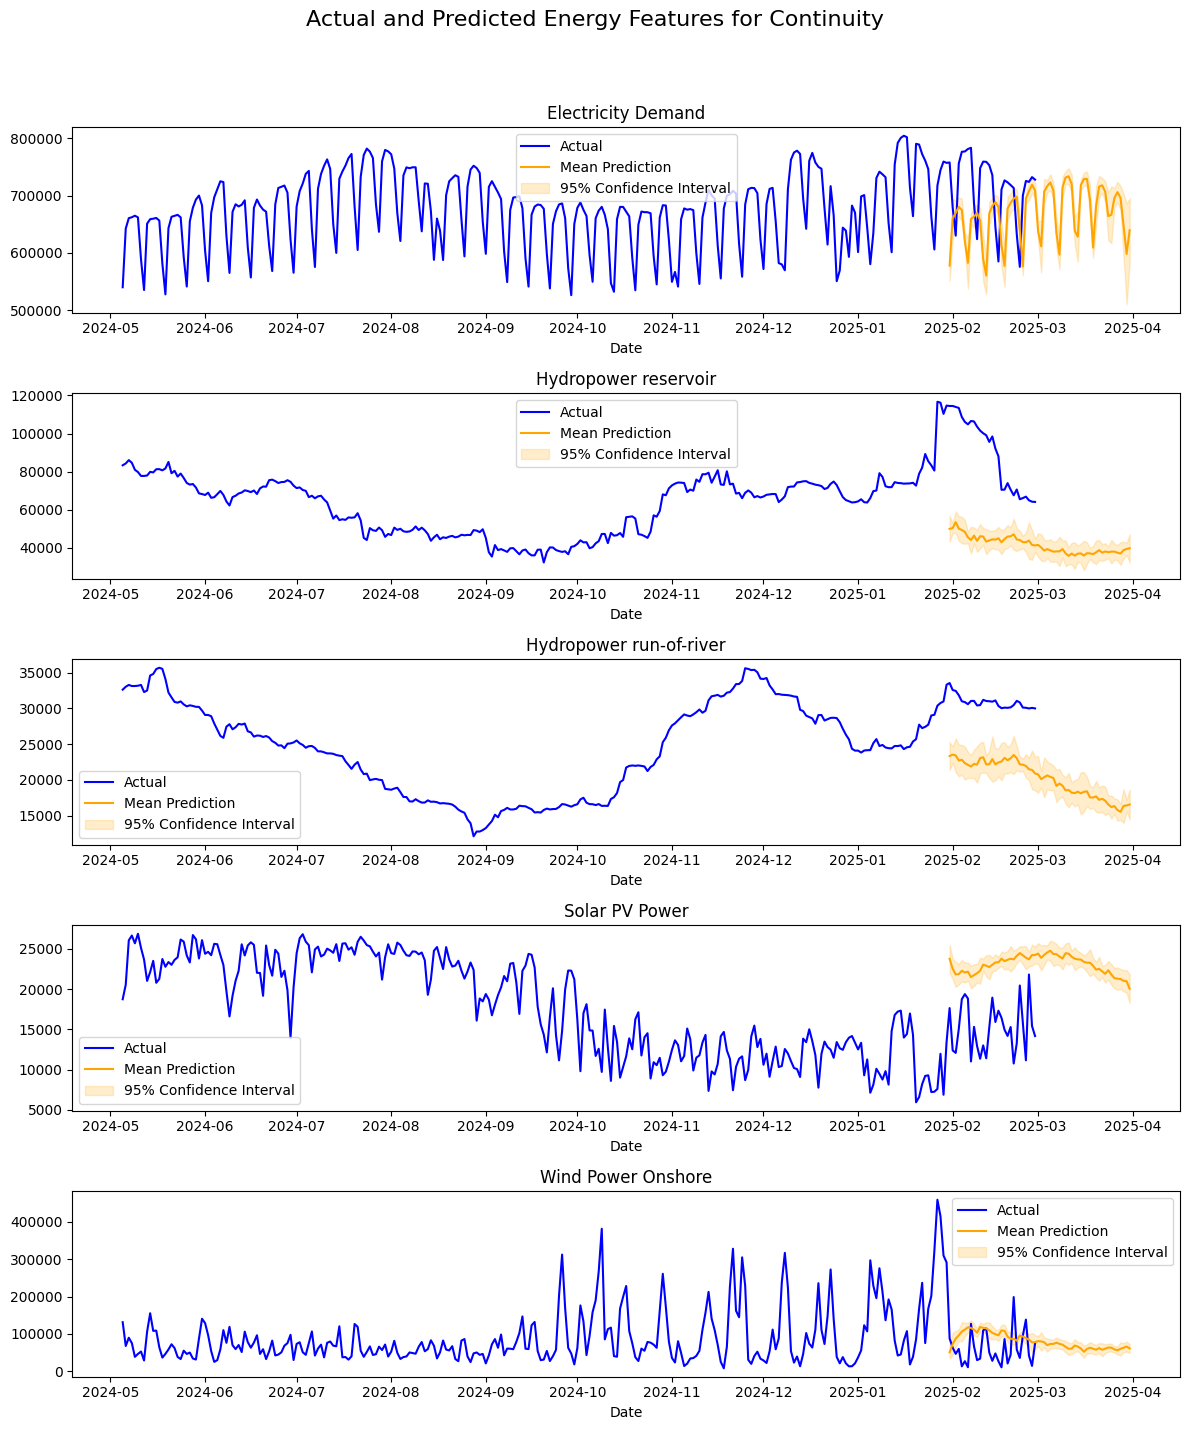

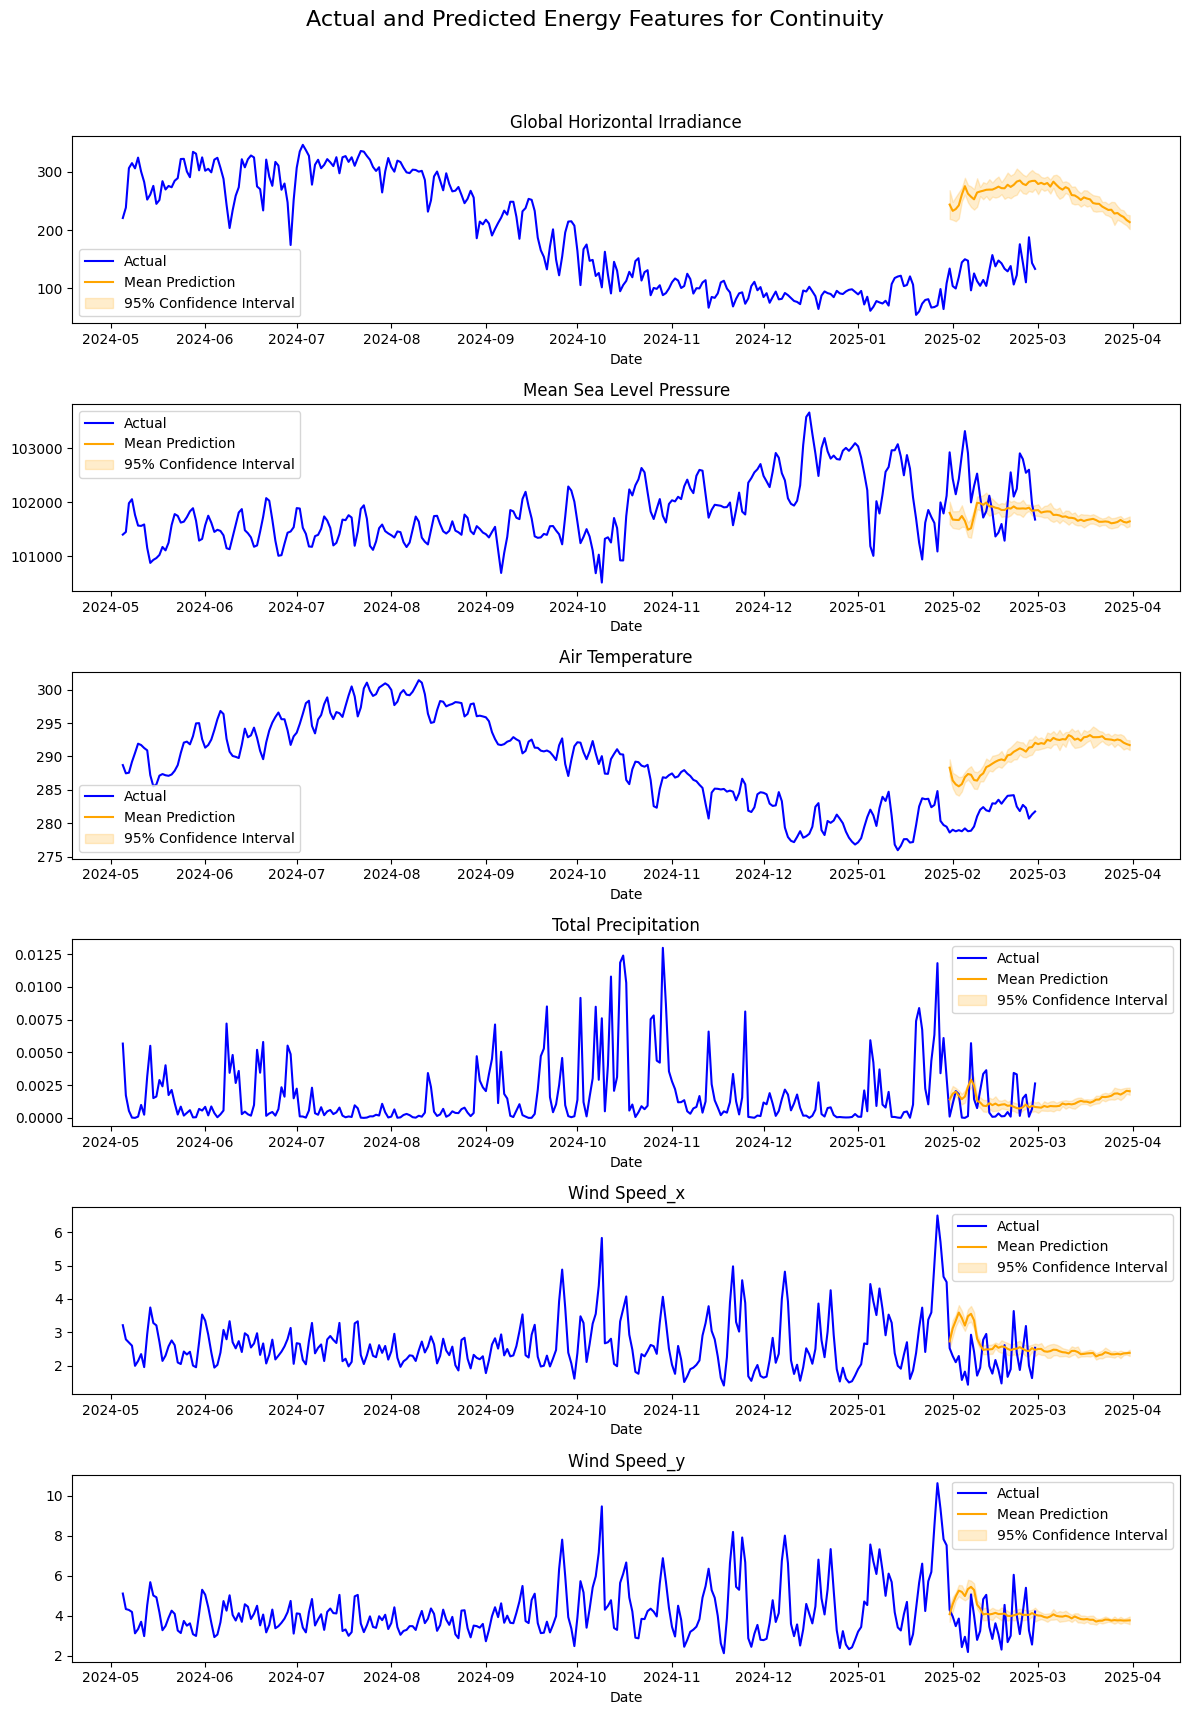

In [28]:
def plot_actual_preds_uncertainty(predictions, targets, data_y):
    
    # Extract the actual data for the last sequence of days
    actual_data = data_y.iloc[-seq_length:]

    # Generate dates for the actual data
    actual_dates = actual_data.index
    
    # Calculate mean, lower bound, and upper bound for the interval of confidence
    mean_pred = predictions.mean(axis=1).squeeze(axis=1)  # Mean across iterations
    std_pred = predictions.std(axis=1).squeeze(axis=1)    # Standard deviation across iterations


    lower_bound = mean_pred - 1.96 * std_pred  # 95% confidence interval lower bound
    upper_bound = mean_pred + 1.96 * std_pred  # 95% confidence interval upper bound

    # Plot each feature in a subplot
    num_features = len(targets)
    plt.figure(figsize=(12, num_features * 3))
    plt.suptitle("Actual and Predicted Energy Features for Continuity", fontsize=16)

    for i, feature in enumerate(targets):
        plt.subplot(num_features, 1, i + 1)
        plt.plot(actual_dates, actual_data[feature], label="Actual", color='blue')
        plt.plot(future_dates, mean_pred[:, i], label="Mean Prediction", color='orange')
        plt.fill_between(future_dates, lower_bound[:, i], upper_bound[:, i], color='orange', alpha=0.2, label="95% Confidence Interval")
        plt.title(feature)
        plt.xlabel("Date")
        plt.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_actual_preds_uncertainty(preds_mc_energy_inv, targets_energy, data_y_energy)
plot_actual_preds_uncertainty(preds_mc_meteo_inv, targets_meteo, data_y_meteo)

In [29]:
targets_energy_interv = []
for i in range(len(targets_energy)):
    targets_energy_interv.append(targets_energy[i])
    targets_energy_interv.append(targets_energy[i] + "_lower_bound")
    targets_energy_interv.append(targets_energy[i] + "_upper_bound")
print(targets_energy_interv)

targets_meteo_interv = []
for i in range(len(targets_meteo)):
    targets_meteo_interv.append(targets_meteo[i])
    targets_meteo_interv.append(targets_meteo[i] + "_lower_bound")
    targets_meteo_interv.append(targets_meteo[i] + "_upper_bound")
print(targets_meteo_interv)

['Electricity Demand', 'Electricity Demand_lower_bound', 'Electricity Demand_upper_bound', 'Hydropower reservoir', 'Hydropower reservoir_lower_bound', 'Hydropower reservoir_upper_bound', 'Hydropower run-of-river', 'Hydropower run-of-river_lower_bound', 'Hydropower run-of-river_upper_bound', 'Solar PV Power', 'Solar PV Power_lower_bound', 'Solar PV Power_upper_bound', 'Wind Power Onshore', 'Wind Power Onshore_lower_bound', 'Wind Power Onshore_upper_bound']
['Global Horizontal Irradiance', 'Global Horizontal Irradiance_lower_bound', 'Global Horizontal Irradiance_upper_bound', 'Mean Sea Level Pressure', 'Mean Sea Level Pressure_lower_bound', 'Mean Sea Level Pressure_upper_bound', 'Air Temperature', 'Air Temperature_lower_bound', 'Air Temperature_upper_bound', 'Total Precipitation', 'Total Precipitation_lower_bound', 'Total Precipitation_upper_bound', 'Wind Speed_x', 'Wind Speed_x_lower_bound', 'Wind Speed_x_upper_bound', 'Wind Speed_y', 'Wind Speed_y_lower_bound', 'Wind Speed_y_upper_boun

In [32]:
def save_preds_df(predictions, targets):
    
    # Calculate mean, lower bound, and upper bound for the interval of confidence
    mean_pred = predictions.mean(axis=1).squeeze(axis=1)  # Mean across iterations
    std_pred = predictions.std(axis=1).squeeze(axis=1)    # Standard deviation across iterations


    lower_bound = mean_pred - 1.96 * std_pred  # 95% confidence interval lower bound
    upper_bound = mean_pred + 1.96 * std_pred  # 95% confidence interval upper bound
    
    # Create a DataFrame for predictions with mean, lower bound, and upper bound
    predictions_df = pd.DataFrame(mean_pred, columns=targets)
    predictions_df.insert(0, 'Date', future_dates)

    # Add lower and upper bounds for each energy feature
    for i, feature in enumerate(targets):
        predictions_df[f"{feature}_lower_bound"] = lower_bound[:, i]
        predictions_df[f"{feature}_upper_bound"] = upper_bound[:, i]
        
    return predictions_df

predictions_energy_df = save_preds_df(preds_mc_energy_inv, targets_energy)
display(predictions_energy_df)

predictions_meteo_df = save_preds_df(preds_mc_meteo_inv, targets_meteo)
display(predictions_meteo_df)

,Date,Electricity Demand,Hydropower reservoir,Hydropower run-of-river,Solar PV Power,Wind Power Onshore,Electricity Demand_lower_bound,Electricity Demand_upper_bound,Hydropower reservoir_lower_bound,Hydropower reservoir_upper_bound,Hydropower run-of-river_lower_bound,Hydropower run-of-river_upper_bound,Solar PV Power_lower_bound,Solar PV Power_upper_bound,Wind Power Onshore_lower_bound,Wind Power Onshore_upper_bound
0,2025-01-31,578005.1250,49975.105469,23346.017578,23777.042969,51102.738281,552055.5625,603954.6875,43114.878906,56835.332031,21395.869141,25296.166016,22032.898438,25521.187500,34489.148438,67716.328125
1,2025-02-01,660379.6875,50369.179688,23534.501953,22527.199219,73626.539062,626377.0625,694382.3125,47823.738281,52914.621094,22391.775391,24677.228516,21256.439453,23797.958984,43740.332031,103512.750000
2,2025-02-02,669845.5000,53470.925781,23427.882812,21832.011719,87589.601562,648488.1250,691202.8750,47808.375000,59133.476562,21059.515625,25796.250000,20289.320312,23374.703125,66517.976562,108661.226562
3,2025-02-03,680426.3125,50086.906250,22714.476562,21862.193359,96442.054688,664190.1250,696662.5000,43634.031250,56539.781250,20505.736328,24923.216797,20578.875000,23145.511719,80955.984375,111928.125000
4,2025-02-04,674903.1250,49369.539062,22815.285156,22284.277344,106519.765625,654930.1250,694876.1250,42464.031250,56275.046875,20744.906250,24885.664062,20956.830078,23611.724609,81181.632812,131857.890625
5,2025-02-05,620672.8750,48360.375000,22348.027344,22075.246094,111755.375000,606769.7500,634576.0000,42131.664062,54589.085938,20043.666016,24652.388672,20835.654297,23314.837891,94038.773438,129471.976562
6,2025-02-06,582801.5000,45485.492188,22110.910156,22171.781250,117849.171875,537920.1250,627682.8750,42470.511719,48500.472656,20295.197266,23926.623047,21057.039062,23286.523438,105181.179688,130517.164062
7,2025-02-07,659434.4375,44067.929688,21870.664062,21500.525391,116050.250000,650144.8125,668724.0625,37046.468750,51089.390625,20280.906250,23460.421875,20117.433594,22883.617188,95999.125000,136101.375000
8,2025-02-08,663461.6250,46415.863281,22235.908203,21746.238281,111427.921875,643992.8125,682930.4375,42182.972656,50648.753906,20249.937500,24221.878906,20396.095703,23096.380859,96548.304688,126307.539062
9,2025-02-09,669817.1250,43665.179688,22152.177734,21983.558594,103523.242188,656137.9375,683496.3125,37866.214844,49464.144531,19625.230469,24679.125000,20843.779297,23123.337891,91852.640625,115193.843750


,Date,Global Horizontal Irradiance,Mean Sea Level Pressure,Air Temperature,Total Precipitation,Wind Speed_x,Wind Speed_y,Global Horizontal Irradiance_lower_bound,Global Horizontal Irradiance_upper_bound,Mean Sea Level Pressure_lower_bound,Mean Sea Level Pressure_upper_bound,Air Temperature_lower_bound,Air Temperature_upper_bound,Total Precipitation_lower_bound,Total Precipitation_upper_bound,Wind Speed_x_lower_bound,Wind Speed_x_upper_bound,Wind Speed_y_lower_bound,Wind Speed_y_upper_bound
0,2025-01-31,243.907303,101804.992188,288.321838,0.001404,2.732763,4.084811,219.254547,268.560059,101597.773438,102012.210938,287.068634,289.575043,0.000932,0.001876,2.529034,2.936492,3.706783,4.462840
1,2025-02-01,233.098434,101681.359375,286.411224,0.001846,3.122253,4.583466,217.622238,248.574631,101528.273438,101834.445312,285.260559,287.561890,0.001256,0.002437,2.872647,3.371860,4.224161,4.942770
2,2025-02-02,236.147247,101675.703125,285.825500,0.001993,3.355609,4.972161,215.258469,257.036041,101516.265625,101835.140625,284.374878,287.276123,0.001701,0.002285,3.185531,3.525688,4.768040,5.176283
3,2025-02-03,242.578537,101673.171875,285.531403,0.001702,3.594592,5.262231,220.079742,265.077332,101507.000000,101839.343750,284.137939,286.924866,0.001321,0.002083,3.371021,3.818164,4.978163,5.546299
4,2025-02-04,261.124542,101746.648438,285.868958,0.001436,3.434122,5.196412,249.552841,272.696259,101547.882812,101945.414062,284.767639,286.970276,0.001037,0.001834,3.216736,3.651509,4.867654,5.525170
5,2025-02-05,275.514191,101656.273438,286.906067,0.001625,3.205711,4.991193,261.119171,289.909210,101544.289062,101768.257812,286.157379,287.654755,0.001164,0.002086,3.045250,3.366173,4.774904,5.207481
6,2025-02-06,262.656494,101494.492188,287.373627,0.002360,3.485929,5.340678,247.632629,277.680359,101360.960938,101628.023438,286.544312,288.202942,0.002066,0.002654,3.277987,3.693872,4.878159,5.803197
7,2025-02-07,257.369965,101519.710938,287.267090,0.002917,3.557579,5.447759,239.714752,275.025177,101345.265625,101694.156250,285.988647,288.545532,0.002339,0.003496,3.322014,3.793144,5.132390,5.763127
8,2025-02-08,252.869553,101751.507812,286.474182,0.002467,3.364625,5.296535,235.178558,270.560547,101635.359375,101867.656250,285.178467,287.769897,0.001864,0.003070,3.116573,3.612678,4.968262,5.624809
9,2025-02-09,264.607117,101990.773438,286.390228,0.001303,2.815873,4.562215,240.123688,289.090546,101873.007812,102108.539062,285.131073,287.649384,0.000995,0.001610,2.696435,2.935311,4.354697,4.769732


In [33]:
predictions_energy_df.to_csv("predictions_energy_interval.csv", index=False)
predictions_meteo_df.to_csv("predictions_meteo_interval.csv", index=False)